In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr
import seaborn as sns
import os
from convection_param.Constants import label_remapping
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size

%load_ext autoreload
%autoreload 2

In [3]:
# Loading predictions on test data set
data_path = '../../Models/NewFormat/Torch/20230415-021732R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_hpoed/TestPredictions.npz'
data = np.load(data_path)
model_name = os.path.basename(os.path.dirname(data_path))
print(data.files)
Y_test, Y_pred, X_expl, Y_expl = data['Y_test'], data['Y_pred'], data['X_expl'], data['Y_expl']

['Y_test', 'Y_pred', 'X_expl', 'Y_expl']


In [4]:
# Load training data
train_data_path = '../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct.npz'
train_data = np.load(train_data_path)
print(train_data.files)
test_coords = train_data['test_coords']

['X_train', 'X_val', 'X_test', 'Y_train', 'Y_val', 'Y_test', 'X_expl', 'Y_expl', 'train_coords', 'val_coords', 'test_coords']


In [5]:
Y_pred_rf = np.load('../Models/from080622/20230421-1613616samples/HistGradientBoostingRegressor/test_preds.npz')['Y_test_pred']
# Y_pred_rf = Y_test.copy() + npr.normal(size=Y_test.shape)
print(Y_pred_rf.shape)
print(Y_pred.shape)

(201702, 189)
(201702, 189)


In [7]:
import pickle
from convection_param.HelperFuncs import StandardScalerOneVar

# with open('scalerdict_X.pickle', 'rb') as handle:
with open('../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct_scalerdict_X.pickle', 'rb') as handle:
    scalerdict_X = pickle.load(handle)

# with open('scalerdict_Y.pickle', 'rb') as handle:
with open('../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct_scalerdict_Y.pickle', 'rb') as handle:
    scalerdict_Y = pickle.load(handle)
    
with open('../../local_data/TrainData/20230111-165428-R2B5_y13y16_vcg-fluxes_rho_fluct_Ymask.pickle', 'rb') as handle:
    Y_mask = pickle.load(handle)

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, d2_pinball_score
from convection_param.HelperFuncs import calc_correlation, compute_correlation_per_var
import datetime

R2_all = r2_score(Y_test, Y_pred, multioutput='raw_values')
R2_varw = r2_score(Y_test[:,Y_mask], Y_pred[:,Y_mask], multioutput='variance_weighted')
MSE = mean_squared_error(Y_test[:,Y_mask], Y_pred[:,Y_mask])
Corr_varw = compute_correlation_per_var(Y_test[:,Y_mask], Y_pred[:,Y_mask], multioutput='variance_weighted')
print(R2_varw)
print(MSE)
print(Corr_varw)

R2_all_rf = r2_score(Y_test, Y_pred_rf, multioutput='raw_values')
print(r2_score(Y_test[:,Y_mask], Y_pred_rf[:,Y_mask], multioutput='variance_weighted'))

0.898280172996608
0.12560661
0.9399669547729596
0.8352374742857839


In [9]:
# Comparison of R2 for 2d fields
print(R2_all[-5:])
print(R2_all_rf[-5:])

[0.77765778 0.79819328 0.85025293 0.85311284 0.89790093]
[0.72719473 0.75088062 0.76951096 0.81261082 0.86004958]


# Plot Pred/Target Distribution/Scatter

In [9]:
from convection_param.HelperFuncs import unique_unsorted

Y_test_unnorm = Y_test.copy()
Y_pred_unnorm = Y_pred.copy()
Y_pred_rf_unnorm = Y_pred_rf.copy()
idx0 = 0
for var, idx_range in zip(*unique_unsorted([e[0] for e in Y_expl], return_counts=True)):
    print(var,idx0,idx0+idx_range)
    scaler = scalerdict_Y[var]
    Y_test_unnorm[...,idx0:idx0+idx_range] = scaler.inverse_transform(Y_test_unnorm[...,idx0:idx0+idx_range])
    Y_pred_unnorm[...,idx0:idx0+idx_range] = scaler.inverse_transform(Y_pred_unnorm[...,idx0:idx0+idx_range])
    Y_pred_rf_unnorm[...,idx0:idx0+idx_range] = scaler.inverse_transform(Y_pred_rf_unnorm[...,idx0:idx0+idx_range])
    idx0 += idx_range

subg_flux_qv 0 23
subg_flux_qc 23 46
subg_flux_qi 46 69
subg_flux_qr 69 92
subg_flux_qs 92 115
subg_flux_h 115 138
subg_flux_u 138 161
subg_flux_v 161 184
clt 184 185
cltp 185 186
liq_detri 186 187
ice_detri 187 188
tot_prec 188 189


Y_pred3d_shape: (201702, 8, 23)


  0%|          | 0/8 [00:00<?, ?it/s]

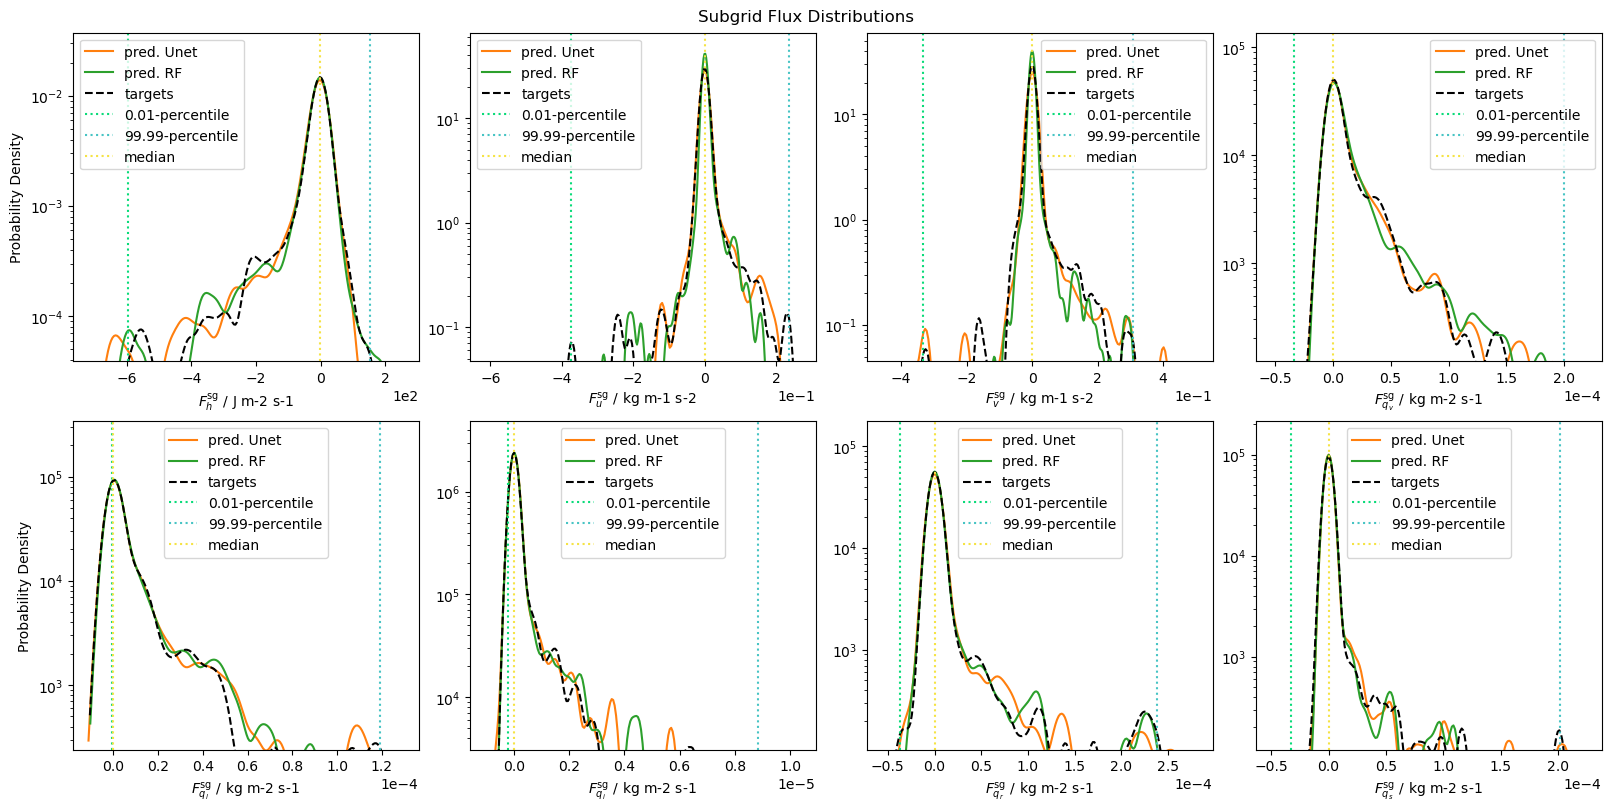

In [11]:
Y_expl3d_uniq = unique_unsorted([e[0] for e in Y_expl[:-5]])
Y_test3d_unnorm = Y_test_unnorm[...,:-5].reshape(Y_test.shape[0], len(Y_expl3d_uniq), -1)
Y_pred3d_unnorm = Y_pred_unnorm[...,:-5].reshape(Y_pred.shape[0], len(Y_expl3d_uniq), -1)
Y_pred3d_rf_unnorm = Y_pred_rf_unnorm[...,:-5].reshape(Y_test.shape[0], len(Y_expl3d_uniq), -1)
Y_mask3d = Y_mask[:-5].reshape(len(Y_expl3d_uniq), -1)
R2_3d = R2_all[:-5].reshape(len(Y_expl3d_uniq), -1)
R2_3d_rf = R2_all_rf[:-5].reshape(len(Y_expl3d_uniq), -1)
print(f'Y_pred3d_shape: {Y_pred3d_unnorm.shape}')

Y3d_vars = ['subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs','subg_flux_h','subg_flux_u','subg_flux_v']
Y3d_vars_units = ['kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','J m-2 s-1','kg m-1 s-2','kg m-1 s-2']
Y3d_var_units = {var: unit for var, unit in zip(Y3d_vars, Y3d_vars_units)}

fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(16,8))

# print(g)
# axes_reordered = axes.ravel()
axes_reordered = np.roll(axes.ravel(), 5)

data_sample = np.s_[:] # possibility only plot subset to save time if wanted

def my_log(x):
    l0_mask = x < 0
    g0_mask = x > 0
    x[l0_mask] = -np.log(np.abs(x[l0_mask]))
    x[g0_mask] = np.log(x[g0_mask])
    return x

for i,(ax, var) in tqdm(enumerate(zip(axes_reordered, Y_expl3d_uniq)), total=len(Y_expl3d_uniq)):
#     hist, edges = np.histogram(Y_pred3d_unnorm[:,i,:].flatten()[data_sample], bins=40)
#     edges_c = (edges[1:]+edges[:-1])/2
#     edges_diff = (edges[1:]-edges[:-1])
    
#     norm = (hist*edges_diff).sum()
#     ax.bar(edges_c, hist/norm, width=np.diff(edges), edgecolor="black", align="edge")
    y_p = Y_pred3d_unnorm[:,i,Y_mask3d[i]].flatten()[data_sample]
    y_p_rf = Y_pred3d_rf_unnorm[:,i,Y_mask3d[i]].flatten()[data_sample]
    y_t = Y_test3d_unnorm[:,i,Y_mask3d[i]].flatten()[data_sample]
    # y_t = my_log(y_t)
    # y_p = my_log(y_p)
    # y_p_rf = my_log(y_p_rf)
    l_quant = np.quantile(y_t, 0.001)
    u_quant = np.quantile(y_t, 0.999)
    ll_quant = np.quantile(y_t, 0.0001)
    uu_quant = np.quantile(y_t, 0.9999)
    median = np.quantile(y_t, 0.5)
    
    ax.hist(y_t, bins=40, alpha=0.0, log=True, density=True) 
    ylims = ax.get_ylim()
    g1 = sns.kdeplot(y_p, log_scale=(False, True), label="pred. Unet", ax=ax)
    g12 = sns.kdeplot(y_p_rf, log_scale=(False, True), label="pred. RF", ax=ax)
    # ax.hist(y[:1000], bins=40, alpha=0.5, density=True, log=True, label="Data")
    g2 = sns.kdeplot(y_t, label="targets", ax=ax, color='black', ls='--')
    ax.axvline(ll_quant, ls=':', color='#09db79', label='0.01-percentile')
    ax.axvline(uu_quant, ls=':', color='#47c4c4', label='99.99-percentile')
    ax.axvline(median, ls=':', color='#F5E344', label='median')
    # ax.set_xlim(ll_quant, uu_quant)
    ax.set_ylim(ylims)
    ax.set_xlabel(label_remapping[var] + ' / ' + Y3d_var_units[var])
    ax.legend()
    ax.set_ylabel('')
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-1,1))

for ax in axes[:,0]:
    ax.set_ylabel('Probability Density')

fig.suptitle('Subgrid Flux Distributions')
# fig.savefig('Figures/SubgridFluxDistributionsOnlyUnet.jpg', dpi=200)
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

corr(subg_flux_u,unet): 0.9456003308296204
idx_list:  [0, 600000, 1200000, 1800000, 2400000, 3000000, 3600000, 4200000, 4639146]
corr(subg_flux_v,unet): 0.8607372641563416
idx_list:  [0, 600000, 1200000, 1800000, 2400000, 3000000, 3600000, 4200000, 4639146]
corr(subg_flux_h,unet): 0.9779712557792664
idx_list:  [0, 600000, 1200000, 1800000, 2400000, 3000000, 3600000, 4200000, 4639146]
corr(subg_flux_qv,unet): 0.9713598489761353
idx_list:  [0, 600000, 1200000, 1800000, 2400000, 3000000, 3600000, 4034040]


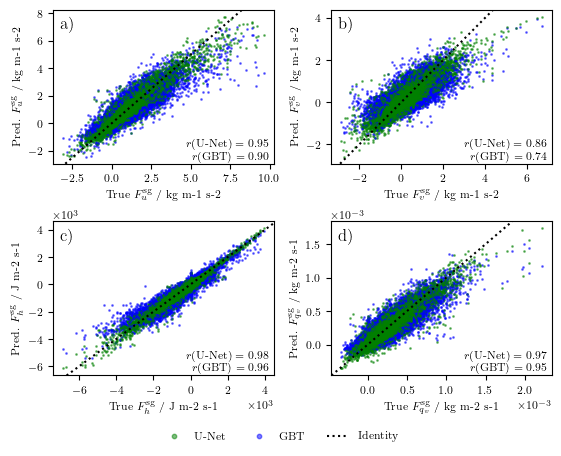

In [12]:
# import matplotlib as mpl
from cycler import cycler
from convection_param.setup_mpl_tex import get_ax_size
setup_mpl_tex()

# n = 4
# cmap = plt.get_cmap('viridis')
# plt.rcParams['axes.prop_cycle'] = cycler(color=[cmap((i+1)/(n-1)) for i in range(n)])
# plt.rcParams['axes.prop_cycle'] = cycler(color=[cmap(0.2), cmap(0.8)])
# plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette())
# plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette("Set2"))
plt.rcParams['axes.prop_cycle'] = cycler(color=['b', 'g'])#, 'y'])
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=set_size('textwidth'))#figsize=(10,10))#

axes_reordered = axes.ravel()
# axes_reordered = np.roll(axes.ravel(), 5)

data_sample = np.s_[:] # possibility to only plot subset to save time if wanted
plot_list = [6,7,5,0]#[1,2,3,4]#

for i,ax in tqdm(zip(plot_list, axes_reordered[:]), total=len(axes_reordered[:])):
    var = Y_expl3d_uniq[i]
    lvl_mask = Y_mask3d[i]
    x = Y_test3d_unnorm[:,i,lvl_mask].flatten()[data_sample]
    y = Y_pred3d_unnorm[:,i,lvl_mask].flatten()[data_sample]
    y_rf = Y_pred3d_rf_unnorm[:,i,lvl_mask].flatten()[data_sample]
    r = calc_correlation(x,y)
    r_rf = calc_correlation(x,y_rf)
    print(f'corr({var},unet): {r}')
    xy = np.stack([x,y], axis=1)
    xy_rf = np.stack([x,y_rf], axis=1)
    data3d = np.concatenate([xy,xy_rf], axis=0)
    pred_3d_df = pd.DataFrame(data3d, columns=['true', 'pred'])
    # pred_3d_df.loc[:len(y),'model'] = 'unet'
    # pred_3d_df.loc[len(y):,'model'] = 'gbt'
    
    # pred_3d_df = pd.DataFrame(xy, columns=['true', 'pred'])
    # pred_3d_df.loc[:len(y),'model'] = 'unet'
    
    # ax.scatter(x, y, s=1)
    # h = ax.hist2d(x, y, bins=100, norm='log')
    # h = ax.hexbin(x, y, bins='log', label='Data')
    # # h2 = ax.hexbin(x, y_rf, bins='log', label='Data')
    # fig.colorbar(h)
    idx_list = list(range(0, len(x), int(6e5))) + [len(x)]
    print('idx_list: ', idx_list)
    for j0,j1 in zip(idx_list[:-1], idx_list[1:]):
        if j0 == 0:
            im1 = ax.scatter(x[j0:j1], y_rf[j0:j1], s=1, label='GBT', alpha=0.5, rasterized=True, color='b')
            im2 = ax.scatter(x[j0:j1], y[j0:j1], s=1, label='U-Net', alpha=0.5, rasterized=True, color='g')
            # im1 = ax.plot(x[j0:j1], y_rf[j0:j1], 'o', ms=1, label='GBT', alpha=0.5, rasterized=True, color='b')
            # im2 = ax.plot(x[j0:j1], y[j0:j1], 'o', ms=1, label='U-Net', alpha=0.5, rasterized=True, color='g')
        else:
            ax.scatter(x[j0:j1], y_rf[j0:j1], s=1, alpha=0.5, rasterized=True, color='b')
            ax.scatter(x[j0:j1], y[j0:j1], s=1, alpha=0.5, rasterized=True, color='g')
            # ax.plot(x[j0:j1], y_rf[j0:j1], 'o', ms=1, alpha=0.5, rasterized=True, color='b')
            # ax.plot(x[j0:j1], y[j0:j1], 'o', ms=1, alpha=0.5, rasterized=True, color='g')
    # sns.scatterplot(data=pred_3d_df, x='true', y='pred', hue='model', ax=ax, s=10, alpha=0.5, legend=True, palette='viridis')
    # sns.kdeplot(data=pred_3d_df, x="true", y="pred", hue="model", fill=True, ax=ax, alpha=0.3)
    
    # axg = sns.kdeplot(x=x, y=y)
    # fig.colorbar(h)
    ax.axline((0,0), slope=1, color='black', ls=':', label='Identity')
    ax.text(0.98, 0.03, fr'$r($U-Net$) = {round(r,2):.2f}$'+'\n'+fr'$r($GBT$) = {round(r_rf,2):.2f}$', transform=ax.transAxes, horizontalalignment='right')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
    ax.set_xlabel('True ' + label_remapping[var] + ' / '+ Y3d_var_units[var])
    ax.set_ylabel('Pred. ' + label_remapping[var] + ' / '+ Y3d_var_units[var])
    
    # ax.spines[['right', 'top']].set_visible(False)
    # ax.legend()
    # break

for ax,letter in zip(axes.ravel(), ['a)', 'b)', 'c)', 'd)']):
    w, h = get_ax_size(ax, fig)
    ax.text(0+0.03, 1-0.03*w/h, letter, transform=ax.transAxes, ha='left', va='top', fontsize=12)

# ax.set_rasterization_zorder(0)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,0,2]]
labels = [labels[i] for i in [1,0,2]]
lgnd = fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.01), loc='upper center', ncols=3, frameon=False)
lgnd.legendHandles[0]._sizes = [10]
lgnd.legendHandles[1]._sizes = [10]

# fig.suptitle('Subgrid Flux Scatter')
# fig.savefig('../../Figures/Pdfplots/SubgridFluxScatter_layered_uvhqv.pdf', dpi=600, bbox_inches='tight')
# fig.savefig('../../Figures/Pdfplots/SubgridFluxScatter_layered_qcqiqrqs.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Plot R2 all vars

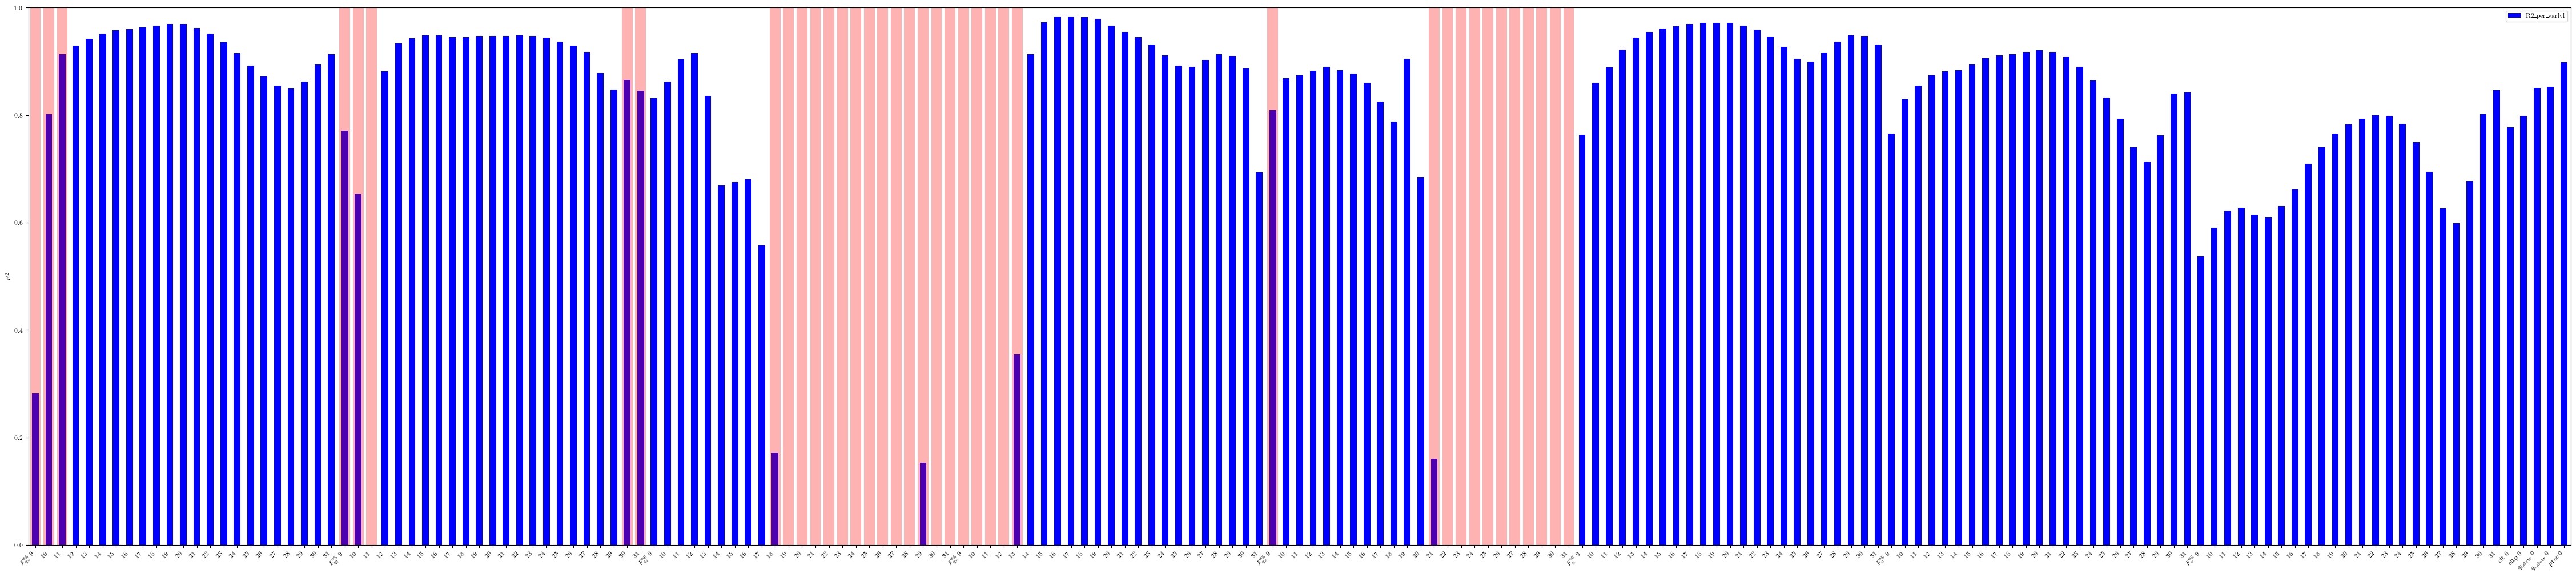

In [13]:
# from convection_param.HelperFuncs import unique_unsorted
# R2_all = r2_score(Y_test, Y_test_hat, multioutput='raw_values')
# R2_all = r2_score(Y_test, Y_pred, multioutput='raw_values')
var_idx = []
var_lvls = []
# for var in variables:
#     new_idx = [i for i,expl in enumerate(Y_expl) if expl[0] == var]
#     new_expls = [expl[1] for i,expl in enumerate(Y_expl) if expl[0] == var]
#     var_idx.append(new_idx)
#     var_lvls.append(new_expls)
# print(var_idx)
variables = []
last_expl = ''
for expl in Y_expl:
    if expl[0] != last_expl:
        last_expl = expl[0]
        variables.append(label_remapping[expl[0]] + ' ' + expl[1])
    else:
        variables.append(expl[1])
    
# variables = [label_remapping[expl[0]] + '_' + expl[1] for expl in Y_expl]
var_idx = [[i] for i,_ in enumerate(Y_expl)]

R2_per_var = []
for idx, var in zip(var_idx, variables):
    R2_per_var.append(np.mean(R2_all[idx]))

# for idx, var, r2 in zip(var_idx, variables, R2_per_var):
#     print(var, r2)

fig, ax = plt.subplots(constrained_layout=True, figsize=(45,10))
R2_per_var_df = pd.DataFrame(R2_per_var, index=variables, columns=['R2_per_varlvl'])
# R2_per_var_df.sort_values("R2", ascending=False).plot(kind='bar', ylabel=r'Average $R^2$', ax=ax)
R2_per_var_df.plot(kind='bar', ylabel=r'$R^2$', ax=ax, legend=False)
ax.bar(range(len(Y_mask)), ~Y_mask, alpha=0.3, color='red')
plt.xticks(rotation=45, ha='right')
# ax.axhline(R2_varw, ls='--', label=r'$\langle R^2\rangle$')
plt.ylim(0,1)
ax.legend()
# fig.savefig(f'Figures/R2PerVarLvl-{model_name}.jpg', dpi=200)
# fig.savefig(f'Figures/R2PerVarLvl-RF.jpg', dpi=200)
# plt.bar(variables, R2_per_var)
plt.show()

In [14]:
print(Y_test[:,-1].min())
print(Y_pred[:,-1].min())
print(Y_pred_rf[:,-1].min())

-0.60618466
-2.0513315
-0.9182657287120809


# Plot Prec distribution

In [16]:
from convection_param.HelperFuncs import precip_rescaling, inv_precip_rescaling

def prec_unit_conv(prec):
    rho_water = 998 # kg m-3 (20°C)
    # Converts prec in kg hour-1 m-2 to mm hour-1
    return prec/rho_water * 1000# * 24

prec = scalerdict_Y['tot_prec'].inverse_transform(Y_test[:,-1])
prec = inv_precip_rescaling(prec, eps=1)
prec = prec_unit_conv(prec)
print(prec.max())

qs = [0.99, 0.999]
quantiles = [np.quantile(prec, q) for q in qs]
print(quantiles)

prec_hat = scalerdict_Y['tot_prec'].inverse_transform(Y_pred[:,-1])
prec_hat = inv_precip_rescaling(prec_hat, eps=1)
prec_hat = prec_unit_conv(prec_hat)

prec_hat_rf = scalerdict_Y['tot_prec'].inverse_transform(Y_pred_rf[:,-1])
prec_hat_rf = inv_precip_rescaling(prec_hat_rf, eps=1)
prec_hat_rf = prec_unit_conv(prec_hat_rf)

212.18768
[52.460060958862194, 101.79026267242419]


95 percentile data 22.276029682159407
95 percentile U-Net 19.75002803802489
95 percentile GBT 16.83184988506834


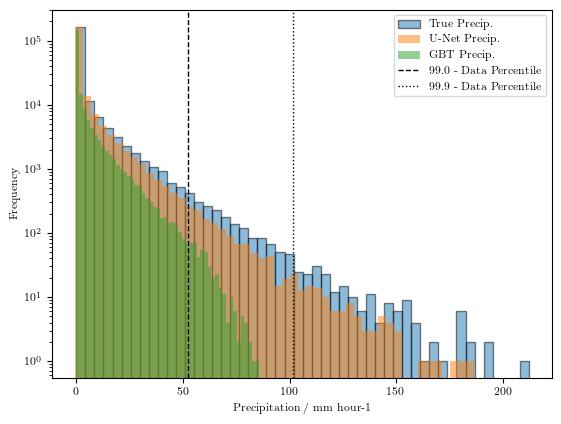

In [19]:
plt.style.use('default')
setup_mpl_tex()
# plt.rcParams['axes.prop_cycle'] =  plt.cycler(color=plt.cm.tab20b.colors)#plt.cycler(color=['b', 'g', 'y'])
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('textwidth'))

ax.hist(prec, bins=50, alpha=0.5, label='True Precip.', edgecolor='black')#, range=(0, 30))
ax.hist(prec_hat, bins=50, alpha=0.5, label='U-Net Precip.')#, range=(0, 30))
ax.hist(prec_hat_rf, bins=50, alpha=0.5, label='GBT Precip.')#, range=(0, 30))
# sns.kdeplot(x=prec, clip=(0,300))
# sns.kdeplot(x=prec_hat, clip=(0,300))
for q,quantile,c in zip(qs, quantiles, ['--',':']):# ['blue','green']):
    ax.axvline(quantile, ls=c, label=f'{q*100} - Data Percentile', color='black', lw=1)
ax.set_yscale('log')
ax.set_xlabel('Precipitation / mm hour-1')
ax.set_ylabel('Frequency')
ax.legend()
print('95 percentile data', np.quantile(prec, 0.95))
print('95 percentile U-Net', np.quantile(prec_hat, 0.95))
print('95 percentile GBT', np.quantile(prec_hat_rf, 0.95))
# ax.spines[['right', 'top']].set_visible(False)

# fig.savefig(f'../../Figures/Pdfplots/PrecipitationDistributionComparison_textwidth.pdf')

plt.show()
# prec_df = pd.DataFrame(np.stack([inv_precip_rescaling(Y_test[:,-1]),
#                                  inv_precip_rescaling(Y_test_hat_rs[:,-1])], axis=1),
#                        columns=['Data', 'Predictions'])

# sns.pairplot(data=prec_df, diag_kws=dict(kde=True, log_scale=True))

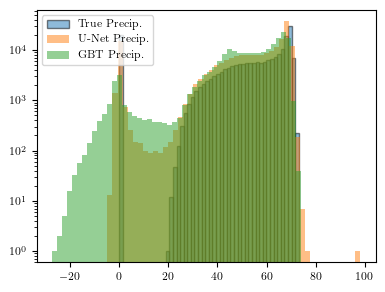

In [44]:
# Other 2d fields

# plt.style.use('default')
# setup_mpl_tex()
# plt.rcParams['axes.prop_cycle'] =  plt.cycler(color=plt.cm.tab20b.colors)#plt.cycler(color=['b', 'g', 'y'])
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('halfa4'))

ax.hist(Y_test_unnorm[:,-5], bins=50, alpha=0.5, label='True Precip.', edgecolor='black')
ax.hist(Y_pred_unnorm[:,-5], bins=50, alpha=0.5, label='U-Net Precip.')
ax.hist(Y_pred_rf_unnorm[:,-5], bins=50, alpha=0.5, label='GBT Precip.')
# sns.kdeplot(x=prec, clip=(0,300))
# sns.kdeplot(x=prec_hat, clip=(0,300))
ax.set_yscale('log')
ax.legend()

plt.show()

# Plot Spatial Evaluation

## Spatial R2

In [19]:
def r2_score_pandas(g):
    if len(g) > 2:
        r2 = r2_score(g['true'], g['pred'])
        return pd.Series(dict(r2 = r2))
    else:
        return pd.Series(dict(r2 = np.nan))

# def r2_score_pandas(g):
#     if len(g) > 2:
#         r2 = r2_score(g['true'], g['pred'], multioutput='variance_weighted')
#         return pd.Series(dict(clat=g['clat'], clon=g['clon'], r2 = r2))
#     else:
#         return pd.Series(dict(clat=g['clat'], clon=g['clon'], r2 = np.nan))

In [ ]:
dfs = []

for i in tqdm(range(len(Y_expl))):
    Y_t = Y_test[:,[i]]
    Y_p = Y_pred[:,[i]]
    
    df_data = np.hstack([test_coords[:,[0]], Y_t, Y_p])
    df = pd.DataFrame(df_data, columns=['cell','true','pred'])
    # df = pd.DataFrame(df_data, columns=['cell','clat','clon','true','pred'])
    df['cell'] = df['cell'].astype(int)
    df = df.groupby(by=['cell']).apply(r2_score_pandas)
    dfs.append(df)
    
Y_test_variances = np.var(Y_test, axis=0)
Y_test_variances.shape

dfs_data = np.hstack([df.values for df in dfs])
R2_spatial_average_data = np.average(dfs_data, axis=1, weights=Y_test_variances)
# np.save('R2_spatial_average_data', R2_spatial_average_data)

# plt.hist(R2_spatial_average_data, range=(0,1), bins=100)
# plt.show()

# R2_spatial_average_data = np.load('./R2_spatial_average_data.npy')
# len(R2_spatial_average_data)

In [ ]:
dfs_data.shape

In [ ]:
df_coord = pd.DataFrame(test_coords, columns=['cell','clat','clon'])
df_coord['cell'] = df_coord['cell'].astype(int)
df_coord = df_coord.groupby('cell').mean().reset_index()

In [ ]:
df = pd.DataFrame(np.hstack([df_coord,R2_spatial_average_data[:,None]]), columns=['cell','clat','clon','R2'])

In [60]:
from convection_param.HelperFuncs import assign_bnd_coords
test = xr.open_dataset('../../Processed/2016080100/ParamPrep/LowRes/R02B05/VertCoarse/dei4_NARVALII_2016080100_fg_DOM01_ML_0000_conv_out_R02B05_m2degr_vertc.nc')
# test = test.dropna('cell')
test = assign_bnd_coords(test)
test['R2'] = xr.DataArray(data=np.full(test.clt.values.shape, np.nan),#np.arange(4596).reshape(1,4596),#
                                    dims=test.clt.dims,
                                    coords=test.clt.coords,
                                    name='R2')

clatclon_test_vals = np.stack([test.clat.values, test.clon.values], axis=1)

In [61]:
shifts = np.isnan(test['u'].values.mean(axis=(0,1))).nonzero()[0]
shifts = shifts - np.arange(len(shifts))
def convert_idx(idx):
    n_previous = np.sum(shifts<=idx)
    idx += n_previous
    return idx

for i,row in df.sort_values('cell').iterrows():
    idx = convert_idx(int(row.cell))
    R2 = row.R2
    
    test['R2'].loc[:,idx] = R2

test.R2.encoding['coordinates'] = 'clat clon'

In [ ]:
from convection_param.HelperFuncs import plot_icon_tricolor
import cartopy.crs as ccrs
import matplotlib as mpl

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(16,8))

current_cmap = mpl.cm.get_cmap(name='Reds').copy()
current_cmap.set_bad(color='#bcb5bb')

R2_plot = test['R2'].values.squeeze()
R2_plot_notna = R2_plot[~np.isnan(R2_plot)]
mapplot = plot_icon_tricolor(ax,
                             test['clon_bnds'].values,
                             test['clat_bnds'].values,
                             test['R2'].values.squeeze(),
                             cmap=current_cmap,
                             vmin=-10)
                             # vmax=h_quantile)
                             #norm=mpl.colors.TwoSlopeNorm(0,vmin=l_quantile,vmax=h_quantile))

ax.coastlines()
# plt.colorbar(mapplot)
ax.gridlines(draw_labels=True)
fig.colorbar(mapplot, orientation='horizontal', aspect=30, pad=0.1, label='R2')

# fig.savefig(f'Figures/MeanRelErrSpatial_var-{var_to_plot}_lvl-{lvl_to_plot}.jpg', dpi=150)
# fig.savefig(f'Figures/RMSESpatialAllVarsLvls-{model_name}.jpg', dpi=200)
# fig.savefig(f'Figures/RMSESpatialAllVarsLvls-RF.jpg', dpi=200)
plt.show()

## Spatial RMSE

In [19]:
# subg_flux_mask = np.array(['subg_flux_h' == e[0] for e in Y_expl])
# print(np.nonzero(subg_flux_mask))
# # subg_flux_mask[115:123] = False
# # subg_flux_mask[130:] = False

In [28]:
# var_to_plot = 'subg_flux_v'
# lvl_to_plot = '31'
# y_plot_idx = [''.join(e) for e in Y_expl].index(var_to_plot+lvl_to_plot)
# print(y_plot_idx)

def get_mean_err(true, pred):
    residuals = (pred - true)**2
    # residuals /= true
    mask = Y_mask #& subg_flux_mask
    residuals = residuals[:,mask]
    return np.mean(residuals, axis=1)

# mean_rel_err = rel_err[:,y_plot_idx]
# mean_err = get_mean_err(Y_test, Y_pred)
Y_pred_mean = np.mean(Y_pred, axis=1)
Y_pred_mean_rf = np.mean(Y_pred_rf, axis=1)
Y_test_mean = np.mean(Y_test, axis=1)
# mean_err_rf = get_mean_err(Y_test, Y_pred_rf)

In [29]:
# bins = 10.0**np.arange(-9,1)
# plt.hist(np.abs(mean_err), bins=bins, log=True, alpha=0.5, label='unet')
# plt.hist(np.abs(mean_err_rf), bins=bins, log=True, alpha=0.5, label='rf')
# plt.xscale('log')
# print(mean_err.mean())
# print(mean_err_rf.mean())
# plt.legend()
# plt.show()

In [41]:
def my_mean(g):
    # result = g['mean_err'].mean()/g['Y_test_mean'].var()
    result = np.sqrt(np.mean((g['Y_test_mean']-g['Y_pred_mean'])**2)/g['Y_test_mean'].var())
    result_rf = np.sqrt(np.mean((g['Y_test_mean']-g['Y_pred_mean_rf'])**2)/g['Y_test_mean'].var())
    return pd.Series(dict(cell=g['cell'].iloc[0],
                     clat=g['clat'].iloc[0],
                     clon=g['clon'].iloc[0],
                     mean_err=result,
                     mean_err_rf=result_rf))

In [42]:
df_data = np.hstack([test_coords, Y_test_mean[:,None], Y_pred_mean[:,None],Y_pred_mean_rf[:,None]])
print(df_data.shape)
df = pd.DataFrame(df_data, columns=['cell','clat','clon','Y_test_mean','Y_pred_mean','Y_pred_mean_rf'])
df['cell'] = df['cell'].astype(int)

# df = df.rename_axis(None, axis=1)
df = df.groupby(by=['cell']).apply(my_mean)
df.index.name = None
# df = df.groupby(by=['cell']).mean().reset_index()
# df = df.groupby(by=['clat','clon']).mean()
# df = df.reset_index(['cell'])
# df = df[['cell', 'clat', 'clon', 'mean_err']]
# df = df.set_index('cell')
df['mean_err'] = np.sqrt(df['mean_err'])
df['mean_err_rf'] = np.sqrt(df['mean_err_rf'])
df.head(3)
# ds = df.reset_index(['clat', 'clon']).to_xarray()
# ds.mean_err.encoding['coordinates'] = 'clat clon'
# ds.mean_err.encoding
# ds
# df['clon'].plot(kind='hist', bins=100)

(201702, 6)


,cell,clat,clon,mean_err,mean_err_rf
0,0.0,0.227570,-1.162987,0.587784,0.746792
1,1.0,0.215492,-1.163250,0.793231,0.882864
2,2.0,0.232381,-1.153582,0.439320,0.592978


In [43]:
from convection_param.HelperFuncs import assign_bnd_coords
test = xr.open_dataset('../../Processed/2016080100/ParamPrep/LowRes/R02B05/VertCoarse/dei4_NARVALII_2016080100_fg_DOM01_ML_0000_conv_out_R02B05_m2degr_vertc.nc')
# test = test.dropna('cell')
test = assign_bnd_coords(test)
test['mean_err'] = xr.DataArray(data=np.full(test.clt.values.shape, np.nan),#np.arange(4596).reshape(1,4596),#
                                    dims=test.clt.dims,
                                    coords=test.clt.coords,
                                    name='mean_err')

test['mean_err_rf'] = xr.DataArray(data=np.full(test.clt.values.shape, np.nan),#np.arange(4596).reshape(1,4596),#
                                    dims=test.clt.dims,
                                    coords=test.clt.coords,
                                    name='mean_err_rf')

# clatclon_test_vals = np.stack([test.clat.values, test.clon.values], axis=1)

In [44]:
shifts = np.isnan(test['u'].values.mean(axis=(0,1))).nonzero()[0]
shifts = shifts - np.arange(len(shifts))
def convert_idx(idx):
    n_previous = np.sum(shifts<=idx)
    idx += n_previous
    return idx

for i,row in df.sort_values('cell').iterrows():
    # idx = np.argmin(np.sum(np.abs(clatclon_test_vals - np.array([row.clat, row.clon])), axis=1))
    idx = convert_idx(int(row.cell))
    mre = row.mean_err
    mre_rf = row.mean_err_rf
    # mre = np.minimum(mre, 1)
    # mre = np.maximum(mre, -1)
    test['mean_err'].loc[:,idx] = mre
    test['mean_err_rf'].loc[:,idx] = mre_rf

test.mean_err.encoding['coordinates'] = 'clat clon'
# test['mean_err'].values[np.isnan(test['mean_err'].values)] = -2

0.26770329848025054
0.9553794089123372


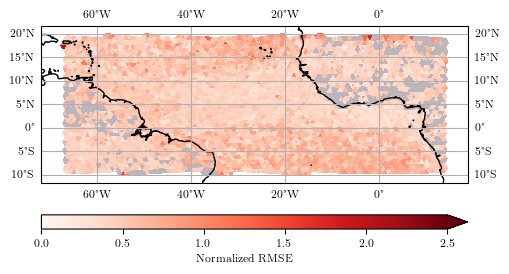

In [47]:
from convection_param.HelperFuncs import plot_icon_tricolor
import cartopy.crs as ccrs
import matplotlib as mpl
from convection_param.setup_mpl_tex import set_size, setup_mpl_tex

setup_mpl_tex()

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=set_size('textwidth'))

current_cmap = mpl.cm.get_cmap(name='Reds').copy()
current_cmap.set_bad(color='#bcb5bb')

mean_err_plot = test['mean_err'].values.squeeze()
mean_err_plot_notna = mean_err_plot[~np.isnan(mean_err_plot)]
l_quantile = np.quantile(mean_err_plot_notna, 0.01)
h_quantile = np.quantile(mean_err_plot_notna, 0.99)
# l_quantile = 0.03603041496582653
# h_quantile = 1.4564998907970883
print(l_quantile) # for unet: 0.03603041496582653
print(h_quantile) # for unet: 1.4564998907970883
mapplot = plot_icon_tricolor(ax,
                             test['clon_bnds'].values,
                             test['clat_bnds'].values,
                             test['mean_err'].values.squeeze(),
                             cmap=current_cmap,
                             vmin=0,
                             # vmax=h_quantile)
                             vmax=2.5)
                             #norm=mpl.colors.TwoSlopeNorm(0,vmin=l_quantile,vmax=h_quantile))

ax.coastlines()
# plt.colorbar(mapplot)
ax.gridlines(draw_labels=True)
fig.colorbar(mapplot, orientation='horizontal', aspect=30, pad=0.1, label='Normalized RMSE', extend='max')
# fig.suptitle(f'Variable {label_remapping[var_to_plot]} on level {lvl_to_plot}')
# fig.suptitle(f'Root Mean Squared Error Average over Lvls and Variables')

# fig.savefig(f'../../Figures/MeanRelErrSpatial_var-{var_to_plot}_lvl-{lvl_to_plot}.jpg', dpi=150)
# fig.savefig(f'../../Figures/RMSESpatialAllVarsLvls-{model_name}_NormalizedByStd.jpg', dpi=200)
# fig.savefig(f'../../Figures/Pdfplots/RMSESpatialAllVarsLvls-RF.pdf')

plt.show()

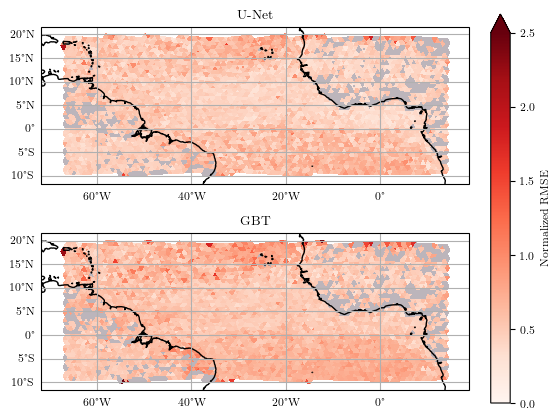

In [76]:
setup_mpl_tex()

fig, (ax1,ax2) = plt.subplots(2, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=set_size('textwidth'), constrained_layout=True)

current_cmap = mpl.cm.get_cmap(name='Reds').copy()
current_cmap.set_bad(color='#bcb5bb')

mapplot1 = plot_icon_tricolor(ax1,
                             test['clon_bnds'].values,
                             test['clat_bnds'].values,
                             test['mean_err'].values.squeeze(),
                             cmap=current_cmap,
                             vmin=0,
                             vmax=2.5)

mapplot2 = plot_icon_tricolor(ax2,
                             test['clon_bnds'].values,
                             test['clat_bnds'].values,
                             test['mean_err_rf'].values.squeeze(),
                             cmap=current_cmap,
                             vmin=0,
                             vmax=2.5)

ax1.coastlines()
ax2.coastlines()
# plt.colorbar(mapplot)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False

ax1.set_title('U-Net')#r'\textbf{U-Net}')
ax2.set_title('GBT')#r'\textbf{GBT}')

fig.colorbar(mapplot1, ax=[ax1,ax2], orientation='vertical', label='Normalized RMSE', extend='max')

# fig.savefig(f'../../Figures/Pdfplots/RMSESpatialAllVarsLvls-UnetGbt.pdf')
plt.show()

# Plot Height Profiles

In [45]:
path = '../../Processed/2016080100/ParamPrep/LowRes/R02B05/VertCoarse/dei4_NARVALII_2016080100_fg_DOM01_ML_0000_conv_out_R02B05_m2degr_vertc.nc'
ds = xr.open_dataset(path).dropna('cell')
z_ifc_fl_appr_mean_km = ds.z_fl.mean(dim='cell').values / 1e3

exclude_idx = np.load('../../local_data/exclude_lvls_th.0001_DOM01.npz')['exclude_lvls_lr'] - 1
mask = ~np.isin(np.arange(len(z_ifc_fl_appr_mean_km)), exclude_idx)
z_ifc_fl_appr_mean_km = z_ifc_fl_appr_mean_km[mask]

In [46]:
# cmap1 = plt.get_cmap('plasma')
# inferno = plt.get_cmap('inferno')
cmap1 = plt.get_cmap('Set2')

# color_mapping = {'subg_flux_h': cmap1(0.5),
#                  'subg_flux_u': cmap1(0.1),
#                  'subg_flux_v': cmap1(0.2),
#                  'subg_flux_qv': cmap2(0.1),
#                  'subg_flux_qc': cmap2(0.3),
#                  'subg_flux_qi': cmap2(0.5),
#                  'subg_flux_qr': cmap2(0.7),
#                  'subg_flux_qs': cmap2(0.9),
color_mapping = {'subg_flux_h': cmap1(1/9),
                 'subg_flux_u': cmap1(2/9),
                 'subg_flux_v': cmap1(3/9),
                 'subg_flux_qv': cmap1(4/9),
                 'subg_flux_qc': cmap1(5/9),
                 'subg_flux_qi': cmap1(6/9),
                 'subg_flux_qr': cmap1(7/9),
                 'subg_flux_qs': cmap1(8/9),
                 'clt': '',
                 'cltp': '',
                 'liq_detri': '',
                 'ice_detri': '',
                 'tot_prec': ''}

var_order = ['subg_flux_u','subg_flux_v','subg_flux_h','subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs']
# var_order = ['subg_flux_u','subg_flux_h','subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs']

subg_flux_u 0.8545346323412686 0.7644097275284606 0.090124904812808
subg_flux_v 0.6981005665886496 0.5090936254916482 0.18900694109700145
subg_flux_h 0.9314360218789072 0.8688455905587449 0.06259043132016229
subg_flux_qv 0.9254546099637231 0.8786048954974465 0.046849714466276615
subg_flux_qc 0.9295204342912121 0.9053364528684897 0.024183981422722378
subg_flux_qi 0.7699306728258545 0.8015579217151619 -0.03162724888930746
subg_flux_qr 0.922685961807717 0.8426577313060775 0.08002823050163954
subg_flux_qs 0.8487381710782077 0.8132530610987281 0.03548510997947962


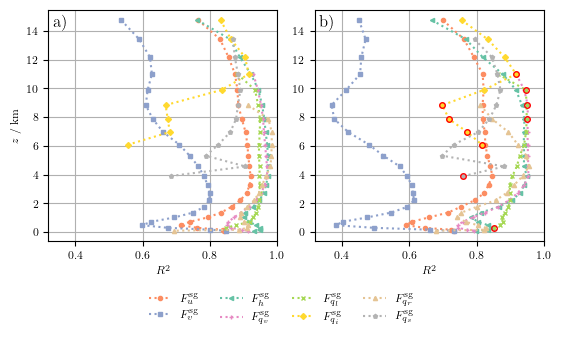

In [47]:
import numpy.ma as ma
from convection_param.setup_mpl_tex import get_ax_size
from matplotlib.lines import Line2D

setup_mpl_tex()
# fig, ax = plt.subplots(constrained_layout=True)
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=set_size('textwidth', ratio=3.2/6.4))
ax, ax2 = axs

Y_mask3d = Y_mask[:-5].reshape(R2_3d.shape)
R2_3d_masked = ma.masked_array(data=R2_3d, mask=~Y_mask3d, fill_value=np.nan)
R2_3d_rf_masked = ma.masked_array(data=R2_3d_rf, mask=~Y_mask3d, fill_value=np.nan)

marker_list = ['o','s','<','+','x','D','^','p','*','P','>','v']#list(Line2D.markers.keys())[2:]
labels = [label_remapping[var] for var in Y3d_vars]
colors = [color_mapping[var] for var in Y3d_vars]
diffs = []
for i,idx in enumerate([Y3d_vars.index(var) for var in var_order]):
    diffs.append(R2_3d_masked[idx]-R2_3d_rf_masked[idx])
    marker = marker_list[i]
    # ax.plot(R2_3d_masked[idx]-R2_3d_rf_masked[idx], z_ifc_fl_appr_mean_km, ':o', label=labels[idx], color=colors[idx], ms=3)
    ax.plot(R2_3d_masked[idx], z_ifc_fl_appr_mean_km, ':', marker=marker, label=labels[idx], color=colors[idx], ms=3)
    ax2.plot(R2_3d_rf_masked[idx], z_ifc_fl_appr_mean_km, ':', marker=marker, label=labels[idx], color=colors[idx], ms=3)
    
    R2_3d_rf_better_masked = R2_3d_rf_masked[idx].copy()
    R2_3d_diff = R2_3d_masked[idx] - R2_3d_rf_masked[idx]
    R2_3d_rf_better_masked.mask = R2_3d_rf_better_masked.mask | (R2_3d_diff > 0)
    ax2.plot(R2_3d_rf_better_masked, z_ifc_fl_appr_mean_km, 'o', mec='red', mfc='none', ms=4)
    print(Y3d_vars[idx], R2_3d_masked[idx].mean(), R2_3d_rf_masked[idx].mean(), R2_3d_masked[idx].mean() - R2_3d_rf_masked[idx].mean())
    # for R2_val, z_ifc_val, R2_diff, flag in zip(R2_3d_rf_better_masked, z_ifc_fl_appr_mean_km, R2_3d_diff, R2_3d_rf_better_masked.mask):
    #     if not flag:
    #         print(R2_val, z_ifc_val, R2_diff, f'{R2_diff*100:.1}')
    #         ax2.text(R2_val, z_ifc_val, f'{R2_diff/R2_val*100:.1f}')
# ax.plot(np.swapaxes(R2_3d_masked,0,1), z_ifc_fl_appr_mean_km, '--o', label=labels, )

# # ax.set_title('Layer Heating (J/kg)')
# fig.suptitle(r'$R^2$ Height Profiles')
# # ax.set_title(r'Neural Network $R^2$ Layer Heating Height Profile')
ax.set_xlabel('$R^2$')
ax2.set_xlabel('$R^2$')
ax.set_ylabel('$z$ / km')
ax.set_xlim(0.32,1)
ax2.set_xlim(0.32,1)
ax.grid()
ax2.grid()

for ax,letter in zip(axs, ['a)', 'b)']):
    w, h = get_ax_size(ax, fig)
    ax.text(0+0.02, 1-0.02*w/h, letter, transform=ax.transAxes, ha='left', va='top', fontsize=12)
    # ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
lgnd = fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.01), loc='upper center', ncols=4, frameon=False)

# fig.savefig(f'Figures/R2HeightProfiles-{model_name}.png', dpi=300)
fig.savefig(f'../../Figures/Pdfplots/R2HeightProfiles.pdf', bbox_inches='tight')

plt.show()

(23,)
(8, 23)


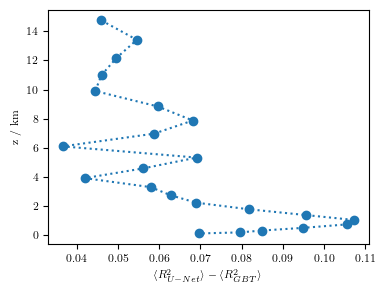

In [48]:
print(diffs[0].shape)
test = np.stack(diffs)
print(test.shape)
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size
setup_mpl_tex()

mean_arr = np.zeros(23)
for diff in diffs:
    # plt.plot(diff, z_ifc_fl_appr_mean_km, '-o')
    bla = diff.copy()
    bla[diff.mask] = 0
    mean_arr += bla

mean_arr /= 7

fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('halfa4'))

ax.plot(mean_arr, z_ifc_fl_appr_mean_km, ':o')
ax.set_ylabel('z / km')
ax.set_xlabel(r'$\langle R^2_{U-Net}\rangle - \langle R^2_{GBT}\rangle$')

# fig.savefig(f'../../Figures/Pdfplots/R2HeightProfiles_difference.pdf', bbox_inches='tight')

plt.show()

In [49]:
# Average R2 improvement per variable
Y_test3d = Y_test[...,:-5].reshape(Y_test.shape[0], len(Y_expl3d_uniq), -1)
Y_pred3d = Y_pred[...,:-5].reshape(Y_test.shape[0], len(Y_expl3d_uniq), -1)
Y_pred3d_rf = Y_pred_rf[...,:-5].reshape(Y_test.shape[0], len(Y_expl3d_uniq), -1)
for i, var in zip(range(Y_test3d.shape[1]), Y3d_vars):
    print(var, r2_score(Y_test3d[:,i,:], Y_pred3d[:,i,:], multioutput='variance_weighted') - r2_score(Y_test3d[:,i,:], Y_pred3d_rf[:,i,:], multioutput='variance_weighted'))
    # print(var, r2_score(Y_test3d[:,i,:], Y_pred3d_rf[:,i,:], multioutput='variance_weighted'))

subg_flux_qv 0.034560067171406694
subg_flux_qc 0.04090546207561652
subg_flux_qi 0.013904483451849359
subg_flux_qr 0.05068879035828022
subg_flux_qs 0.0362153238707954
subg_flux_h 0.03738656106327776
subg_flux_u 0.08510336944094132
subg_flux_v 0.20049401208237516
